<a href="https://colab.research.google.com/github/karthikvijayakumar/EVA/blob/vijkar_development/Project%206/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

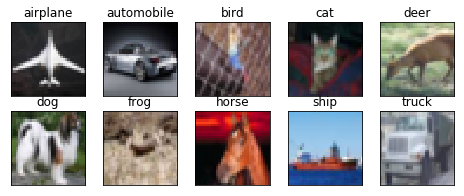

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers.merge import concatenate

dropout_rate = 0.15

# This returns a tensor
inputs = Input(shape=(32,32,3))

#Normal convolution
x = Convolution2D(128, (3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(rate = 1-dropout_rate)(x)

#Spatially seperable convolution ( 3x1 convolution followed by a 1x3 convolution )
x = Convolution2D(256, (3,1), activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate = 1-dropout_rate)(x)

x = Convolution2D(256, (1,3), activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate = 1-dropout_rate)(x)

# Transition block ( Max pooling layer + 1x1 convolution )
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Convolution2D(64,(1,1), activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate = 1-dropout_rate)(x)

#Depthwise seperable convolution
x = SeparableConv2D(128, (3,3), activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate = 1-dropout_rate)(x)

#Grouped convolution
gp_conv_1_33 = Convolution2D(256, (3,3), padding = 'same', activation = 'relu')(x)
gp_conv_1_33 = BatchNormalization()(gp_conv_1_33)
gp_conv_1_33 = Dropout(rate = 1-dropout_rate)(gp_conv_1_33)

gp_conv_1_55 = Convolution2D(256, (5,5), padding = 'same', activation = 'relu')(x)
gp_conv_1_55 = BatchNormalization()(gp_conv_1_55)
gp_conv_1_55 = Dropout(rate = 1-dropout_rate)(gp_conv_1_55)

#Note: The padding = 'same' ensure that the image sizes post convolution are padded to be the same size as the inputs to the layer.
#Without the padding we wont be able to concatenate the 2.

#Merge the 2 convolution layers
x = concatenate([gp_conv_1_33, gp_conv_1_55] )

# Transition block ( Max pooling layer + 1x1 convolution )
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Convolution2D(64,(1,1), activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate = 1-dropout_rate)(x)

#Grouped convolution
gp_conv_1_33_dil_1 = Convolution2D(128, (3,3), dilation_rate= 1 , padding = 'same', activation = 'relu')(x) # This is just normal convolution ( dilation = 1 )
gp_conv_1_33_dil_1 = BatchNormalization()(gp_conv_1_33_dil_1)
gp_conv_1_33_dil_1 = Dropout(rate = 1-dropout_rate)(gp_conv_1_33_dil_1)

gp_conv_1_33_dil_2 = Convolution2D(128, (3,3), dilation_rate = 2, padding = 'same', activation = 'relu')(x) # Convolution with dilation 2
gp_conv_1_33_dil_2 = BatchNormalization()(gp_conv_1_33_dil_2)
gp_conv_1_33_dil_2 = Dropout(rate = 1-dropout_rate)(gp_conv_1_33_dil_2)

#Note: The padding = 'same' ensure that the image sizes post convolution are padded to be the same size as the inputs to the layer.
#Without the padding we wont be able to concatenate the 2.

# #Merge the 2 convolution layers
x = concatenate( [gp_conv_1_33_dil_1, gp_conv_1_33_dil_2] )

#Convolution layer to convert to 10 layers
x = Convolution2D(10, (6,6) )(x)
x = Flatten()(x)
x = Activation('softmax')

In [0]:
model = Model(inputs = inputs, outputs = x )\
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 30, 30, 128)  3584        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 30, 30, 128)  0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 28, 30, 256)  98560       dropout_11[0][0]                 
__________________________________________________________________________________________________
dropout_12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 91s 232ms/step - loss: 2.2948 - acc: 0.1527 - val_loss: 2.3354 - val_acc: 0.1000

Epoch 00001: val_acc improved from -inf to 0.10000, saving model to weights.variety_convolutions.best.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0029126214.
390/390 [==============================] - 86s 220ms/step - loss: 2.2269 - acc: 0.1592 - val_loss: 2.3370 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.10000
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0028301887.
390/390 [==============================] - 85s 219ms/step - loss: 2.2976 - acc: 0.1178 - val_loss: 2.3525 - val_acc: 0.1000

Epoch 00003: val_acc did not improve from 0.10000
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0027522936.
390/390 [==============================] - 85s 218ms/step - loss: 2.2667 - acc: 0

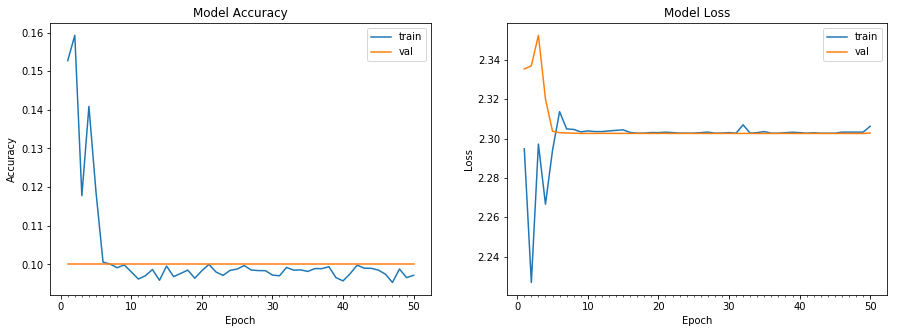

Accuracy on test data is: 10.00


In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.03 * epoch), 10)

filepath="weights.variety_convolutions.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, LearningRateScheduler(scheduler, verbose=1)]

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), callbacks = callbacks_list,
                                 verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

This is rather strange. Both the loss function value and accuracy practically did not change for either training or validation across 50 epochs! After 90 mins of training we still have a model with 10 acccuracy.

I dont understand what exactly is the cause here. I guess it doesnt make sense to jumble up several convolution types together. Is there a single major cause or are there a few causes for the network to perform so poorly I dont know.

I have not picked up the best model weights even though I have computed and stored them through callbacks. This is since the validation accuracy practically never changed and there wasnt much to gain from recompiling the model with those weights.